<a href="https://colab.research.google.com/github/jackiekuen2/notes-handson-ml-tf/blob/master/ch4_PolynomialRegression_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 2. Polynomial Regression

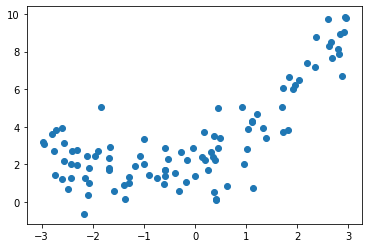

In [0]:
# Example: Quadratic Equation
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y)
plt.show()

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
 
# First, fit_transform X to X_poly
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

[0.38871229]
[0.38871229 0.15109725]


X_poly now contains
- the original feature of X and
- the square of feature of X

In [0]:
# Second, fit X_poly to LinearRegression model
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

print(lin_reg.intercept_, lin_reg.coef_)

[1.98102638] [[1.04146016 0.47840519]]


The model estimates:
- y_hat = 0.513\*x1^2 + 0.999\*x1 + 1.972

## 2-I. Learning Curves

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.ylim(bottom=-5.0, top=5.0)

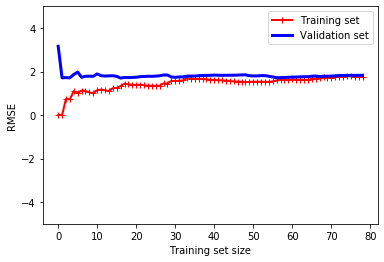

In [0]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

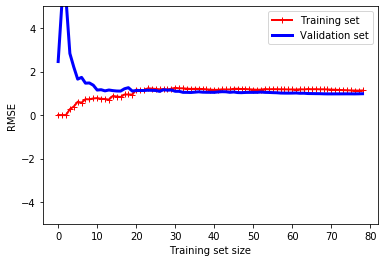

In [0]:
# Fitting 10th degree polynomial model
from sklearn.pipeline import Pipeline

polynomial_regression_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression_pipeline, X, y)

## Regression Line

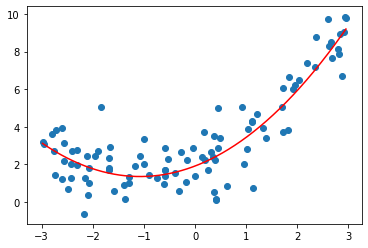

In [0]:
plt.scatter(X, y)
data_X = np.linspace(np.min(X), np.max(X), 1024)
plt.plot(data_X, polynomial_regression_pipeline.predict(data_X.reshape(-1, 1)), color='r')
plt.show()

## 2-II-A. Ridge Regression

### 1. Perform Ridge Regression using closed-form equation

In [0]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.03759406]])

### 2. Perform Ridge Regression using SGD (L2 Regularization)

In [0]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty='l2') # Add l2 regularization term, this is simply Ridge Regression
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.00730623])

### 2-II-B Lasso Regression

### Perform Lasso Regression using SGD (L1 Regularization)

In [0]:
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.01696348])

In [0]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.99074104])

### 2-II-C Elastic Net

In [0]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.9909425])

### 2-II-D Early Stopping

In [0]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Prepare Polynomial data and Standardization
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [0]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate='constant', eta0=0.0005)

# Early Stopping
minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # warm_start=True, meaning continue where it left off instead of restarting from scratch
    y_val_pred = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_pred)
    # if validation error < minimum val error, set it to minimum, and clone the model
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [0]:
best_epoch

118

In [0]:
best_model.score

<bound method RegressorMixin.score of SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=True)>